In [1]:
import sys, os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
# %matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

from model import get_model, get_data, get_options

np.set_printoptions(linewidth=120)

In [5]:
parser = get_options(train.setup_standard_options(no_config=True, ))

args = parser.parse_args([])

args.no_test = True

args.device = 'cuda:0'
args.seed = 0

args.logdate = True
args.tblog = False
args.txtlog = False
args.saveroot = 'trained_nets'
args.save_freq = -1

args.dataset = 'svhn'
args.dataset = 'mnist'
# for emnist change link: 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
args.use_val = True
args.val_per = 1/6

args.num_workers = 4
args.batch_size = 128

args.start_epoch = 0
args.epochs = 2

args.name = 'test-ll'

args.criterion = 'mse'
args.disc_steps = 1
args.disc_gp = 10.

args.emb_dim = 2
args.latent_dim = 16

args.disc_hidden = [128, 128, 128]
args.enc_hidden = [256, 128]
args.func_hidden = [256, 128]


now = time.strftime("%y-%m-%d-%H%M%S")
if args.logdate:
    args.name = os.path.join(args.name, now)
args.save_dir = os.path.join(args.saveroot, args.name)
print('Save dir: {}'.format(args.save_dir))

if args.tblog or args.txtlog:
    util.create_dir(args.save_dir)
    print('Logging in {}'.format(args.save_dir))
logger = util.Logger(args.save_dir, tensorboard=args.tblog, txt=args.txtlog)

# Set seed
if not hasattr(args, 'seed') or args.seed is None:
    args.seed = util.get_random_seed()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass

if not torch.cuda.is_available():
    args.device = 'cpu'
print('Using device {} - random seed set to {}'.format(args.device, args.seed))

Save dir: trained_nets/test-ll/19-10-29-112320
Using device cuda:0 - random seed set to 0


In [6]:
datasets = train.load_data(args=args)
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=args.batch_size, num_workers=args.num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('Input: {}, Output: {}'.format(args.din, args.dout))
print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))
print('Batch size: {} samples'.format(args.batch_size))

Input: (1, 28, 28), Output: 10
traindata len=50000, trainloader len=391
valdata len=10000, valloader len=79
testdata len=10000, testloader len=79
Batch size: 128 samples


In [7]:
# Define Model
args.total_samples = {'train': 0, 'val':0, 'test': 0}
epoch = 0
best_loss = None
all_train_stats = []
all_val_stats = []
all_test_stats = []

args.din_flat = int(np.product(args.din))

model = get_model(args)

scheduler = None#torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.2)

model.to(args.device)
print(model)
print(model.optim)
print('Model has {} parameters'.format(util.count_parameters(model)))

Supervised_LL(
  (func): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (enc): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=128, out_features=16, bias=True)
    )
  )
  (disc): Class_Discriminator(
    (net): Sequential(
      (0): Linear(in_features=18, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=128, out_features=128, bias=True)
      

In [8]:
# Reseed after model init
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass


if args.no_test:
    print('Will not run test data after training')
else:
    raise NotImplementedError

Will not run test data after training


In [13]:
for _ in range(args.epochs):

    model.reset()

    train_stats = util.StatsMeter()
    train_stats.shallow_join(model.stats)

    train_stats = train.run_epoch(model, trainloader, args, mode='train',
                                  epoch=epoch, print_freq=args.print_freq, logger=logger, silent=True,
                                  viz_criterion_args=args.viz_criterion_args,
                                  stats=train_stats, )

    all_train_stats.append(train_stats.copy())

    if valloader is not None:
        model.reset()

        val_stats = util.StatsMeter()
        val_stats.shallow_join(model.stats)

        val_stats = train.run_epoch(model, valloader, args, mode='val',
                                  epoch=epoch, print_freq=args.print_freq, logger=logger, silent=True,
                                  viz_criterion_args=args.viz_criterion_args,
                                  stats=val_stats, )

        all_val_stats.append(val_stats.copy())

    print('[ {} ] Epoch {} Train={:.3f} ({:.3f}), Val={:.3f} ({:.3f})'.format(
        time.strftime("%H:%M:%S"), epoch+1,
        train_stats['accuracy'].avg.item(), train_stats['loss'].avg.item(),
        val_stats['accuracy'].avg.item(), val_stats['loss'].avg.item(),
    ))

    if args.save_freq > 0 and epoch % args.save_freq == 0:


        ckpt = {
            'epoch': epoch+1,

            'args': args,

            'model_str': str(model),
            'model_state': model.state_dict(),
            'all_train_stats': all_train_stats,
        }
        if args.track_best:
            av_loss = train_stats['loss'].avg.item() if valloader is None else val_stats['loss'].avg.item()
            is_best = best_loss is None or av_loss < best_loss
            if is_best:
                best_loss = av_loss
                best_epoch = epoch

            ckpt['loss'] = av_loss
            ckpt['best_loss'] = best_loss
            ckpt['best_epoch'] = best_epoch
        if len(all_val_stats):
            ckpt['all_val_stats'] = all_val_stats
        path = save_checkpoint(ckpt, args.save_dir, is_best=is_best, epoch=epoch+1)
        print('--- checkpoint saved to {} ---'.format(path))

    epoch += 1

[ 11:26:27 ] Epoch 3 Train=0.811 (6.789), Val=0.811 (5.740)
[ 11:26:44 ] Epoch 4 Train=0.856 (4.941), Val=0.856 (4.243)


In [10]:
model.disc.table.weight

Parameter containing:
tensor([[ 1.1083, -1.0371],
        [ 0.4131,  1.4472],
        [ 1.5627, -1.1772],
        [-1.1235,  0.1288],
        [-2.2679, -0.4945],
        [ 0.7381,  0.8050],
        [-0.0820, -0.8055],
        [ 0.4665, -1.7692],
        [ 0.4217, -0.6077],
        [ 0.2480, -1.2172]], device='cuda:0', requires_grad=True)

In [11]:
# plt.switch_backend('Qt5Agg')

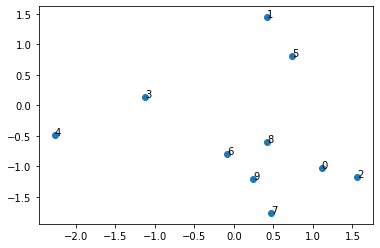

In [12]:
plt.figure()
cls = model.disc.table.weight.data.cpu().numpy()
plt.scatter(*cls.T)
for i in range(args.dout):
    plt.annotate(str(i), cls[i])

In [54]:
N, D, M = 128, 16, 4
K = 8

dist = nn.CosineSimilarity(-1)

X = torch.randn(N, D)
table = nn.Embedding(K, M)
X.shape, table.weight.shape

(torch.Size([128, 16]), torch.Size([8, 4]))

In [48]:
true_net = models.make_MLP(D, M, hidden_dims=[32, 32], nonlin='prelu')
true_net

Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=32, out_features=4, bias=True)
)

In [56]:
net = models.make_MLP(D, M, hidden_dims=[32, 32], nonlin='prelu')
optim = util.get_optimizer('adam', net.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()

net

Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=32, out_features=4, bias=True)
)

In [49]:
outs = true_net(X)
Y = dist(outs.unsqueeze(0), table.weight.data.unsqueeze(1)).min(0)[1]
Y.shape

torch.Size([128])

In [50]:
Y

tensor([1, 1, 1, 6, 3, 1, 7, 1, 1, 1, 5, 3, 7, 3, 5, 1, 6, 5, 6, 5, 5, 1, 1, 5,
        3, 5, 1, 7, 3, 4, 5, 7, 1, 5, 1, 3, 6, 6, 1, 1, 1, 4, 5, 6, 1, 1, 3, 6,
        1, 6, 3, 6, 1, 5, 5, 6, 4, 5, 5, 5, 1, 6, 1, 1, 1, 6, 7, 1, 5, 6, 1, 5,
        5, 5, 1, 5, 7, 1, 1, 6, 5, 7, 7, 5, 1, 3, 5, 1, 6, 4, 5, 5, 1, 6, 7, 5,
        3, 5, 7, 7, 6, 5, 5, 6, 1, 1, 1, 6, 6, 5, 6, 5, 6, 6, 1, 5, 5, 6, 7, 5,
        1, 1, 1, 6, 2, 6, 5, 4])

In [51]:
table(Y)

tensor([[ 1.0384, -0.0998, -1.1449, -0.5497],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [-0.1437, -1.2939, -0.4401, -0.2319],
        [-1.7765,  0.4460, -0.1173,  0.7555],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [ 1.1117,  0.4840, -0.6688, -0.8903],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [-0.9356,  0.5489, -0.2530,  1.1919],
        [-1.7765,  0.4460, -0.1173,  0.7555],
        [ 1.1117,  0.4840, -0.6688, -0.8903],
        [-1.7765,  0.4460, -0.1173,  0.7555],
        [-0.9356,  0.5489, -0.2530,  1.1919],
        [ 1.0384, -0.0998, -1.1449, -0.5497],
        [-0.1437, -1.2939, -0.4401, -0.2319],
        [-0.9356,  0.5489, -0.2530,  1.1919],
        [-0.1437, -1.2939, -0.4401, -0.2319],
        [-0.9356,  0.5489, -0.2530,  1.1919],
        [-0.9356,  0.5489, -0.2530,  1.1919],
        [ 1.0384, -0.0998, -1.1449

In [53]:
pred = net(X)

torch.Size([128, 4])

In [57]:
criterion(table(Y), pred).backward()

In [59]:
table.weight.data

tensor([[-0.4577, -1.0110, -1.0143,  1.6214],
        [ 0.1723, -0.4228, -0.3409,  1.2453],
        [-0.0940,  3.2353,  0.6170,  1.1947],
        [ 1.3173,  0.3238,  0.0400,  0.1116],
        [ 1.8122, -1.5468, -0.5019, -0.8159],
        [-0.3358, -0.6961, -0.5540, -0.8864],
        [ 0.5595,  0.5447, -1.0494, -0.1568],
        [ 0.8991,  1.6202,  2.4490, -0.2844]])

In [58]:
table.weight.grad

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0094, -0.0619, -0.0658,  0.1946],
        [-0.0002,  0.0125,  0.0015,  0.0051],
        [ 0.0449,  0.0146, -0.0019,  0.0032],
        [ 0.0339, -0.0309, -0.0124, -0.0158],
        [-0.0533, -0.0975, -0.0934, -0.1138],
        [ 0.0464,  0.0581, -0.1148, -0.0116],
        [ 0.0377,  0.0776,  0.1126, -0.0121]])

<IPython.core.display.Javascript object>


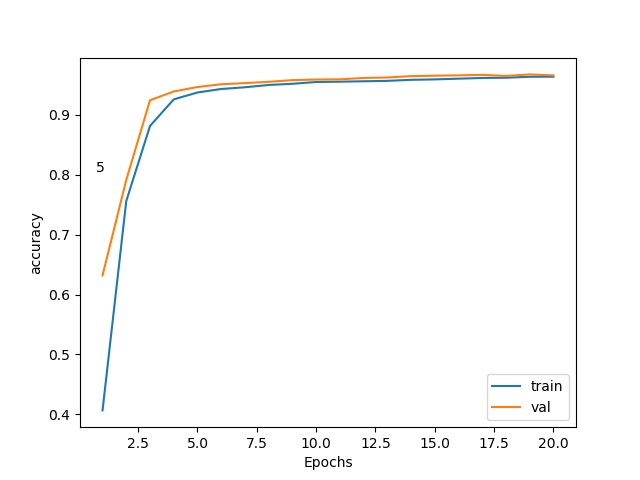

In [8]:
stat_key = 'accuracy'

figax = None
figax = util.plot_stat(all_train_stats, key=stat_key, figax=figax, label='train')
figax = util.plot_stat(all_val_stats, key=stat_key, figax=figax, label='val')
fig, ax = figax
plt.sca(ax)
plt.xlabel('Epochs')
plt.ylabel(stat_key)
plt.legend()